# Sentiment Analysis - ML Models on Intel Reviews

Analyzing the Intel Processor dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.


### Importing required libraries

In [ ]:
%pip install pandas nltk seaborn matplotlib scikit-learn xgboost joblib


In [19]:
import pandas as pd
import re
import nltk
import seaborn as sns
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import load, dump
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Load the Training Data

In [5]:
# Load data from CSV
df = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

In [6]:
df.head()

,Product,Rating,Date,Source,Review,Sentiment
0,intel-i7-14700k,5.0,November/2023,amazon,far good cpu monster run very nicely boost max...,positive
1,intel-i7-14700k,5.0,January/2024,amazon,guess everyone right thing hot went brand aio ...,positive
2,intel-i7-14700k,5.0,March/2024,amazon,intel ik delivers impressive performance high ...,positive
3,intel-i7-14700k,5.0,May/2024,amazon,purchase cpu please also purchase alongside pu...,positive
4,intel-i7-14700k,5.0,April/2024,amazon,professional cpu isnt designed average user ho...,positive


In [7]:
#Column names

print(f"Feature names : {df.columns.values}")

Feature names : ['Product' 'Rating' 'Date' 'Source' 'Review' 'Sentiment']


In [8]:
#Check for null values

df.isnull().sum()

Product      2
Rating       2
Date         0
Source       2
Review       0
Sentiment    0
dtype: int64

In [9]:
#Getting the record where 'verified_reviews' is null 

df[df['Review'].isna() == True]

,Product,Rating,Date,Source,Review,Sentiment


In [10]:
#We will drop the null record

df.dropna(inplace=True)

In [11]:
print(f"Dataset shape after dropping null values : {df.shape}")

Dataset shape after dropping null values : (7528, 6)


## Preprocessing & Data Cleaning

To build the corpus from the 'Review' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the word to the corpus

In [14]:
# Data Cleaning 2.0
corpus = []
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['Review'])
    review = review.lower().split()
    review = [word for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. RANDOM FOREST ML MODEL

Training Accuracy: 0.9988375954832281
Testing Accuracy: 0.8871181938911022


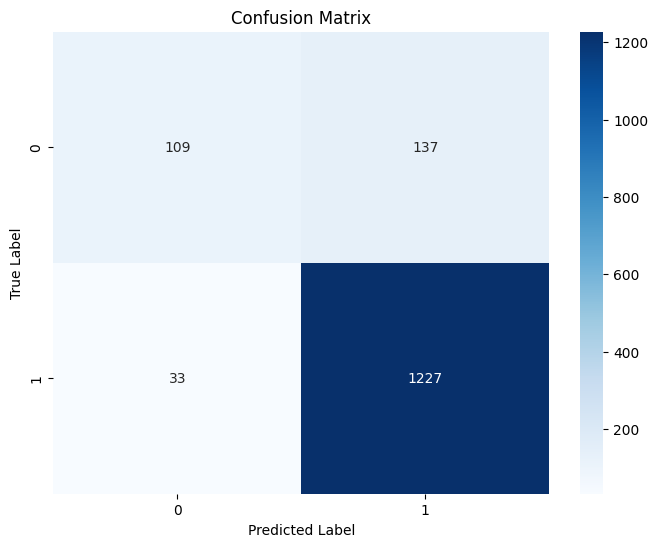

['../ml_trained_model/random_forest/rf_classifier.joblib']

In [17]:

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

# Save the vectorizer to a file
dump(vectorizer, '../ml_trained_model/random_forest/vectorizer.joblib')

# Change labels to positive (1) and negative (0)
df['label'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Store the trained Random Forest classifier
dump(rf_classifier, '../ml_trained_model/random_forest/rf_classifier.joblib')

In [20]:

# Perform cross-validation on the training set
cv_scores_train = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Mean cross-validation score on the training set
mean_cv_score_train = cv_scores_train.mean()
print("Mean Cross-Validation Accuracy on Training Set:", mean_cv_score_train)

# Predictions on the test set
y_test_pred_cv = rf_classifier.predict(X_test)

# Accuracy on the test set
test_accuracy_cv = accuracy_score(y_test, y_test_pred_cv)
print("Accuracy on Test Set (without cross-validation):", test_accuracy)

# Accuracy on the test set using cross-validation
test_accuracy_cv = accuracy_score(y_test, y_test_pred_cv)
print("Accuracy on Test Set (with cross-validation):", test_accuracy_cv)


Mean Cross-Validation Accuracy on Training Set: 0.8782811099929694
Accuracy on Test Set (without cross-validation): 0.8871181938911022
Accuracy on Test Set (with cross-validation): 0.8871181938911022


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Testing Accuracy with Best Model: 0.8871181938911022


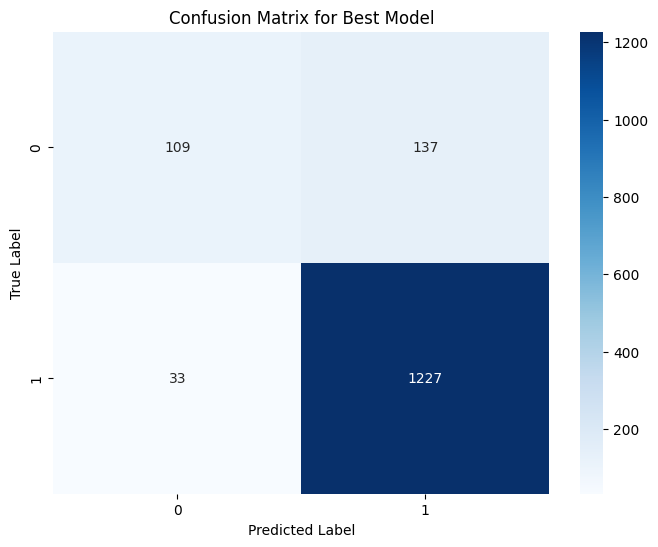

In [21]:

# Load the pre-trained Random Forest classifier
rf_classifier = load('../ml_trained_model/random_forest/rf_classifier.joblib')

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialize Random Forest classifier with best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)

# Train the classifier with best parameters
best_rf_classifier.fit(X_train, y_train)

# Save the trained model to a file named model_rf_best.pkl
dump(best_rf_classifier, '../ml_trained_model/random_forest/tuned_rf_model.joblib')

# Predictions with best model
y_test_pred_best = best_rf_classifier.predict(X_test)

# Testing accuracy with best model
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)
print("Testing Accuracy with Best Model:", test_accuracy_best)

# Confusion matrix for best model
conf_matrix_best = confusion_matrix(y_test, y_test_pred_best)

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Model')
plt.show()


### Deploying the trained model on the resultant data.

In [27]:

# Load new data
new_data = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

# Load the saved model
rf_classifier = load('../ml_trained_model/random_forest/tuned_rf_model.joblib')  # Load the model from model_rf_best.pkl

# Load the CountVectorizer used during training
vectorizer = load('../ml_trained_model/random_forest/vectorizer.joblib')  # Assuming you saved the vectorizer during training

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize NLTK Stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert tokens to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuations
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply data cleaning to the "Sentence" column
new_data['Cleaned_Sentence'] = new_data['Review'].apply(clean_text)

# Feature extraction using CountVectorizer
X_new = vectorizer.transform(new_data['Cleaned_Sentence'])

# Predictions
y_pred_new = rf_classifier.predict(X_new)

# Convert labels to 'positive' and 'negative'
y_pred_new_str = ['Positive' if label == 1 else 'Negative' for label in y_pred_new]

# Add predicted label to the existing dataframe
new_data['Predicted_Label'] = y_pred_new_str

# Save the dataframe to CSV
new_data.to_csv('../analyzed_data/random_forest_analyzed_data.csv', index=False)

print("Predictions saved.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Predictions saved.


## 2. SUPPORT VECTOR ML MODEL

Training Accuracy: 0.938558618399203
Testing Accuracy: 0.8751660026560425


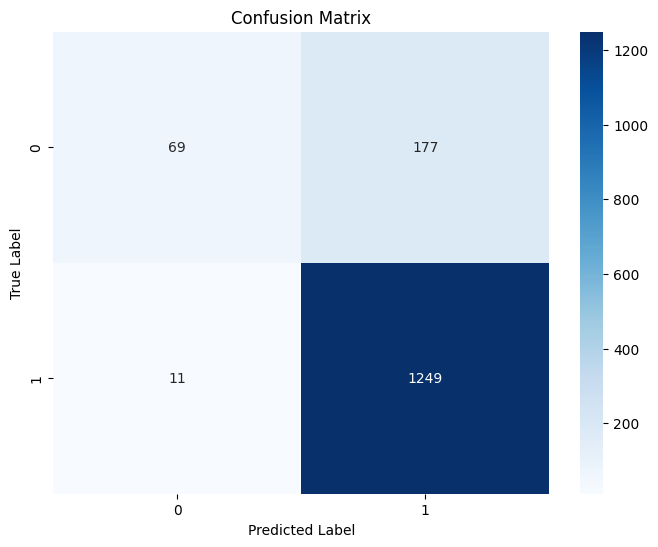

['../ml_trained_model/support_vector/svm_classifier.joblib']

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

# Load data from CSV
# df = pd.read_csv('data_with_sentiment.csv')

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

# Save the vectorizer to a file
dump(vectorizer, '../ml_trained_model/support_vector/vectorizer.joblib')

# Change labels to positive (1) and negative (0)
df['label'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = svm_classifier.predict(X_train)
y_test_pred = svm_classifier.predict(X_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

dump(svm_classifier, '../ml_trained_model/support_vector/svm_classifier.joblib')


In [29]:

# Perform cross-validation on training data
cv_train_accuracy = cross_val_score(svm_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Training Accuracy:", cv_train_accuracy.mean())

# Perform cross-validation on testing data
cv_test_accuracy = cross_val_score(svm_classifier, X_test, y_test, cv=5, scoring='accuracy')
print("Cross-Validation Testing Accuracy:", cv_test_accuracy.mean())


Cross-Validation Training Accuracy: 0.8478905722281193
Cross-Validation Testing Accuracy: 0.8366548590790082


Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Accuracy Score: 0.8925968762492935
Training Accuracy: 0.9943559096945551
Testing Accuracy: 0.9057104913678619


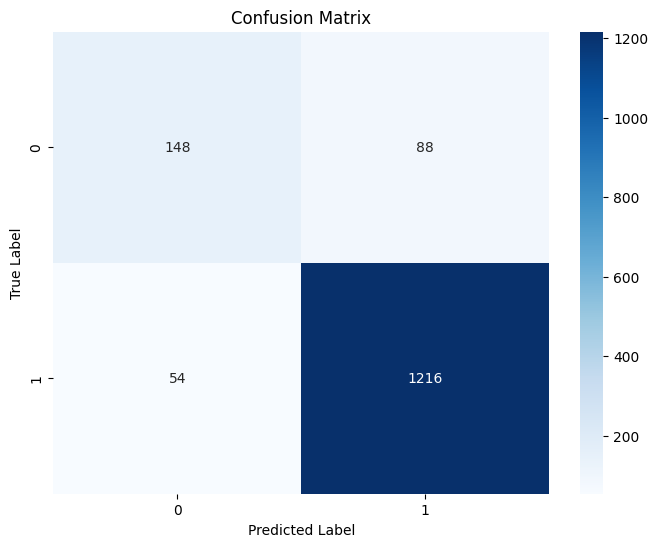

['../ml_trained_model/support_vector/tuned_svm_classifier.joblib']

In [30]:

# Load data from CSV
df = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

# Change labels to positive (1) and negative (0)
df['label'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Load the saved SVM model
svm_classifier = load('../ml_trained_model/support_vector/svm_classifier.joblib')

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best accuracy score
print("Best Accuracy Score:", grid_search.best_score_)

# Predictions
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the tuned SVM model
dump(grid_search.best_estimator_, '../ml_trained_model/support_vector/tuned_svm_classifier.joblib')


### Deploying the trained model on the resultant data.

In [31]:
# Load the saved SVM model
svm_classifier = load('../ml_trained_model/support_vector/svm_classifier.joblib')  # Load the SVM model

# Load the CountVectorizer used during training
vectorizer = load('../ml_trained_model/support_vector/vectorizer.joblib')  # Assuming you saved the vectorizer during training

# Load the new data
new_data = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize NLTK Stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert tokens to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuations
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply data cleaning to the "Sentence" column
new_data['Cleaned_Sentence'] = new_data['Review'].apply(clean_text)

# Feature extraction using CountVectorizer
X_new = vectorizer.transform(new_data['Cleaned_Sentence'])

# Predictions
y_pred_new = svm_classifier.predict(X_new)

# Convert labels to 'Positive' and 'Negative'
y_pred_new_str = ['Positive' if label == 1 else 'Negative' for label in y_pred_new]

# Add predicted label to the existing dataframe
new_data['Predicted_Label'] = y_pred_new_str

# Save the dataframe to CSV
new_data.to_csv('../analyzed_data/support_vector_analyzed_data.csv', index=False)

print("Predictions saved.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Predictions saved.


## 3. XGBOOST ML MODEL

Training Accuracy: 0.9460491367861886
Testing Accuracy: 0.901062416998672


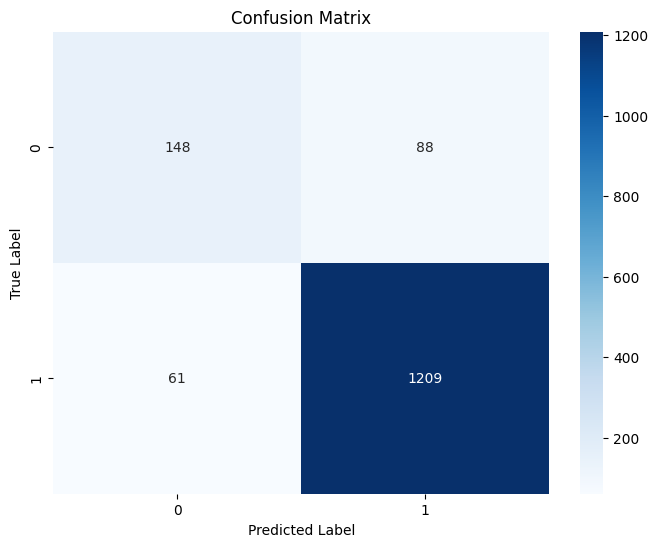

['../ml_trained_model/xgboost/xgb_model.joblib']

In [33]:


# Load data from CSV
# df = pd.read_csv('data_with_sentiment.csv')

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

# Save the vectorizer to a file
dump(vectorizer, '../ml_trained_model/xgboost/vectorizer.joblib')

# Change labels to positive (1) and negative (0)
df['label'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier()

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

dump(xgb_classifier, '../ml_trained_model/xgboost/xgb_model.joblib')



Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Training Accuracy: 0.9593293492695883
Testing Accuracy: 0.900398406374502


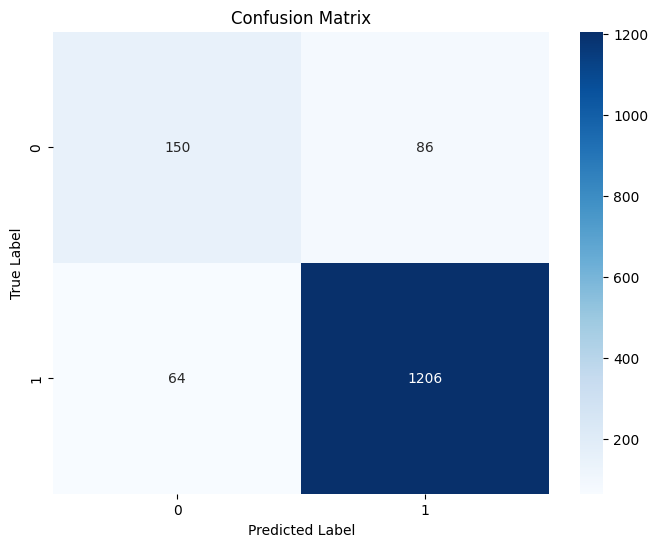

['../ml_trained_model/xgboost/tuned_xgb_model.joblib']

In [34]:


# Load data from CSV
df = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Review'])

# Save the vectorizer to a file
dump(vectorizer, '../ml_trained_model/xgboost/vectorizer.joblib')

# Change labels to positive (1) and negative (0)
df['label'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_classifier = load('../ml_trained_model/xgboost/xgb_model.joblib')

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialize XGBoost classifier with best parameter
best_xgb_classifier = XGBClassifier(**best_params)

# Train the classifier with best parameters
best_xgb_classifier.fit(X_train, y_train)

# Predictions
y_train_pred = best_xgb_classifier.predict(X_train)
y_test_pred = best_xgb_classifier.predict(X_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the trained XGBoost classifier with best parameters
dump(best_xgb_classifier, '../ml_trained_model/xgboost/tuned_xgb_model.joblib')


### Deploying the trained model on the resultant data.

In [35]:
# new_data = pd.read_csv('SentimentBulk.csv')
# new_data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)
new_data = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

new_data.dropna(inplace=True)

new_data.head()


,Product,Rating,Date,Source,Review,Sentiment
0,intel-i7-14700k,5.0,November/2023,amazon,far good cpu monster run very nicely boost max...,positive
1,intel-i7-14700k,5.0,January/2024,amazon,guess everyone right thing hot went brand aio ...,positive
2,intel-i7-14700k,5.0,March/2024,amazon,intel ik delivers impressive performance high ...,positive
3,intel-i7-14700k,5.0,May/2024,amazon,purchase cpu please also purchase alongside pu...,positive
4,intel-i7-14700k,5.0,April/2024,amazon,professional cpu isnt designed average user ho...,positive


In [36]:

# Load the saved XGBoost model
xgb_classifier = load('../ml_trained_model/xgboost/tuned_xgb_model.joblib')  # Load the XGBoost model

# Load the CountVectorizer used during training
vectorizer = load('../ml_trained_model/xgboost/vectorizer.joblib')  # Assuming you saved the vectorizer during training

# Load the new data
new_data = pd.read_csv('../review_data/dataset_7(senti)_roberta.csv')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize NLTK Stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Convert tokens to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuations
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply data cleaning to the "Sentence" column
new_data['Cleaned_Sentence'] = new_data['Review'].apply(clean_text)

# Feature extraction using CountVectorizer
X_new = vectorizer.transform(new_data['Cleaned_Sentence'])

# Predictions
y_pred_new = xgb_classifier.predict(X_new)

# Convert labels to 'Positive' and 'Negative'
y_pred_new_str = ['Positive' if label == 1 else 'Negative' for label in y_pred_new]

# Add predicted label to the existing dataframe
new_data['Predicted_Label'] = y_pred_new_str

# Save the dataframe to CSV
new_data.to_csv('../analyzed_data/xgboost_analyzed_data.csv', index=False)

print("Predictions saved.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Predictions saved.


## Testing for Array of Strings

In [37]:

# Load the saved model
# classifier = load('tuned_rf_model.joblib')  # Load the Random Forest model
classifier = load('../ml_trained_model/xgboost/tuned_xgb_model.joblib')  # Load the XGBoost model
# classifier = load('tuned_svm_classifier.joblib') #Load the Sector Vector model


# Load the CountVectorizer used during training
vectorizer = load('../ml_trained_model/xgboost/vectorizer.joblib')  # Assuming you saved the vectorizer during training

# Function to predict sentiment of input strings
def predict_sentiment(input_strings):
    # Feature extraction using CountVectorizer
    X_test = vectorizer.transform(input_strings)

    # Predictions
    y_pred = classifier.predict(X_test)

    # Convert labels to 'Positive' and 'Negative'
    predictions = ['Positive' if label == 1 else 'Negative' for label in y_pred]

    # Create a DataFrame with input strings and predicted labels
    predictions_df = pd.DataFrame({'Input_String': input_strings, 'Predicted_Label': predictions})

    return predictions_df

# Test strings
test_strings = [
    "This product is amazing!",
    "disappoint with this purchase",
    "satisfactory",
    "bad",
    "Great value for the price",
    "Product worse",
    "Sucks, I wanna die",
    "I want to get another one its so good",
    "Worse",
    "sometim game answer question correctli alexa say got wrong answer like turn dont light away home",
    "abl",
    "Not bad",
    "Good",
    "high price"
    
]
# Predict sentiment of input strings
test_predictions = predict_sentiment(test_strings)

# Display predictions
print("Sentiment Predictions for Test Strings:")
print(test_predictions)


Sentiment Predictions for Test Strings:
                                         Input_String Predicted_Label
0                            This product is amazing!        Positive
1                       disappoint with this purchase        Negative
2                                        satisfactory        Negative
3                                                 bad        Negative
4                           Great value for the price        Positive
5                                       Product worse        Negative
6                                  Sucks, I wanna die        Negative
7               I want to get another one its so good        Positive
8                                               Worse        Negative
9   sometim game answer question correctli alexa s...        Positive
10                                                abl        Negative
11                                            Not bad        Negative
12                                               G

## Evaluating Best Model Based on Performance -

In [38]:
rf_classifier = load('../ml_trained_model/random_forest/tuned_rf_model.joblib')  # Load the Random Forest model
xgb_classifier = load('../ml_trained_model/xgboost/tuned_xgb_model.joblib')  # Load the XGBoost model
svm_classifier = load('../ml_trained_model/support_vector/tuned_svm_classifier.joblib') # Load the Support Vector model

# Load the CountVectorizer used during training
vectorizer = load('../ml_trained_model/xgboost/vectorizer.joblib')

# Function to predict sentiment of input strings
def predict_sentiment(classifier, input_strings):
    X_test = vectorizer.transform(input_strings)

    y_pred = classifier.predict(X_test)

    predictions = ['Positive' if label == 1 else 'Negative' for label in y_pred]

    return predictions

# Test strings
test_strings = [
    "This product is amazing!",
    "disappoint with this purchase",
    "Value for money",
    "bad",
    "Great value for the price",
    "Product worse",
    "Sucks, I wanna die",
    "I want to get another one its so good",
    "Worse",
    "sometim game answer question correctli alexa say got wrong answer like turn dont light away home",
    "abl",
    "Not bad",
    "Good"
]

# Define the true labels for the test strings
true_labels = ['Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive']

def evaluate_model(classifier, test_strings, true_labels):
    predictions = predict_sentiment(classifier, test_strings)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, pos_label='Positive', average='binary')
    recall = recall_score(true_labels, predictions, pos_label='Positive', average='binary')
    f1 = f1_score(true_labels, predictions, pos_label='Positive', average='binary')

    return accuracy, precision, recall, f1

# Evaluate Random Forest model
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_classifier, test_strings, true_labels)
print("Random Forest Model Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print()

# Evaluate XGBoost model
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(xgb_classifier, test_strings, true_labels)
print("XGBoost Model Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1-score:", xgb_f1)
print()

# Evaluate SVM model
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_classifier, test_strings, true_labels)
print("SVM Model Metrics:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)


Random Forest Model Metrics:
Accuracy: 0.6153846153846154
Precision: 0.6666666666666666
Recall: 0.5714285714285714
F1-score: 0.6153846153846154

XGBoost Model Metrics:
Accuracy: 0.6923076923076923
Precision: 0.8
Recall: 0.5714285714285714
F1-score: 0.6666666666666666

SVM Model Metrics:
Accuracy: 0.6923076923076923
Precision: 0.8
Recall: 0.5714285714285714
F1-score: 0.6666666666666666


### We derive the following from the above results -
1. Both XGBoost and SVM models show equal performance across accuracy, precision, recall, and F1-score.
2. XGBoost models typically require more computational resources and have longer training times compared to SVMs but often achieve better performance.
3. If computational resources allow and interpretability isn't a concern, XGBoost might be preferred for its slightly higher accuracy.
4. Alternatively, if simplicity and ease of interpretation are prioritized, SVM could be a suitable choice.